<a href="https://colab.research.google.com/github/f247805/DeepLearning/blob/main/Copy_of_DeepLEarningCrypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.16.1
!pip install keras==3.1.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 826.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found

In [ ]:
!pip uninstall keras
!pip install keras==3.1.1

Found existing installation: keras 3.1.1
Uninstalling keras-3.1.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-3.1.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? y
  Successfully uninstalled keras-3.1.1
  Using cached keras-3.1.1-py3-none-any.whl (1.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [ ]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.16.1
Keras version: 3.1.1


In [ ]:
# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [ ]:
# Set environment variable for TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Force TensorFlow to use CPU for deterministic behavior
tf.config.experimental.set_visible_devices([], 'GPU')


In [ ]:
# Loading the dataset
df = pd.read_csv('/content/tweet.csv')
df = df[['text', 'Label']]
df


,text,Label
0,#Financial Action Task Force Is suggesting to ...,positive
1,#MakeCryptoLegal! #BTC #Crypto,positive
2,#MakeCryptoLegal,positive
3,#MakeCryptoLegal,positive
4,#MakeCryptoLegal,positive
...,...,...
762,cryptocurrency can increase finance is it true,positive
763,cryptocurrency is good for finance,positive
764,cryptocurrency can increase funds,positive
765,it's a good idea to make cryptocurrency legal ...,positive


In [ ]:
# Preprocessing
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['text'] = df['text'].apply(preprocess_text)
df


,text,Label
0,financial action task force is suggesting to l...,positive
1,makecryptolegal btc crypto,positive
2,makecryptolegal,positive
3,makecryptolegal,positive
4,makecryptolegal,positive
...,...,...
762,cryptocurrency can increase finance is it true,positive
763,cryptocurrency is good for finance,positive
764,cryptocurrency can increase funds,positive
765,its a good idea to make cryptocurrency legal b...,positive


In [ ]:
# Encode labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

df


,text,Label
0,financial action task force is suggesting to l...,1
1,makecryptolegal btc crypto,1
2,makecryptolegal,1
3,makecryptolegal,1
4,makecryptolegal,1
...,...,...
762,cryptocurrency can increase finance is it true,1
763,cryptocurrency is good for finance,1
764,cryptocurrency can increase funds,1
765,its a good idea to make cryptocurrency legal b...,1


In [ ]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df['text'], df['Label'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Apply SMOTE to handle class imbalance
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Vectorize the text data using the tokenizer
X_train_sequences = tokenizer.texts_to_sequences(X_train)
max_len = max(map(len, X_train_sequences))
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_padded, y_train.values.reshape(-1, 1))

# Convert padded sequences back to text data
X_train_resampled_text = tokenizer.sequences_to_texts(X_train_resampled)

# Create a tokenizer after resampling
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_resampled_text)

# Vectorize the text data using the tokenizer
X_train_sequences = tokenizer.texts_to_sequences(X_train_resampled_text)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
max_len = max(map(len, X_train_sequences))

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')

# Clear previous TensorFlow session
tf.keras.backend.clear_session()


In [ ]:
# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 2 == 0 and epoch > 0:
        return lr * 0.9
    return lr


In [ ]:
# Build the model
model = Sequential()
model.add(Input(shape=(max_len,)))
model.add(Embedding(input_dim=vocab_size, output_dim=512, mask_zero=True))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout=0.4, recurrent_dropout=0.6))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lr_scheduler)

# Training
history = model.fit(X_train_padded, y_train_resampled, validation_data=(X_val_padded, y_val),
                    epochs=5, batch_size=128, callbacks=[early_stopping, lr_schedule])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test accuracy: {accuracy}')


y_pred = model.predict(X_test_padded)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))


Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6649 - loss: 0.6807 - val_accuracy: 0.5739 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7150 - loss: 0.6086 - val_accuracy: 0.6435 - val_loss: 0.6418 - learning_rate: 0.0010
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7784 - loss: 0.5046 - val_accuracy: 0.7826 - val_loss: 0.5569 - learning_rate: 9.0000e-04
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8573 - loss: 0.3818 - val_accuracy: 0.8522 - val_loss: 0.3748 - learning_rate: 9.0000e-04
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9129 - loss: 0.2667 - val_accuracy: 0.8522 - val_loss: 0.3163 - learning_rate: 8.1000e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8785 - loss: 0.3274
Test accuracy: 0.8706896305084229
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
              precision    recall  f1-score   support

           0       0.66      0.84      0.74        2

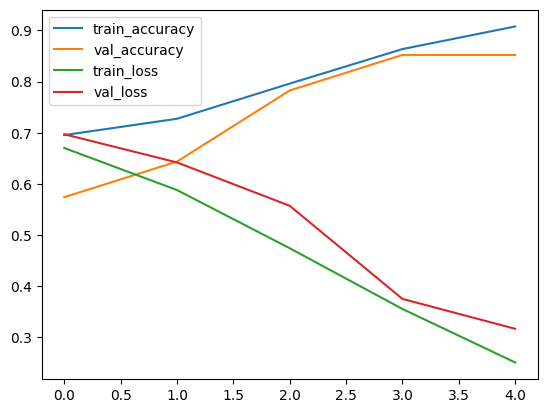

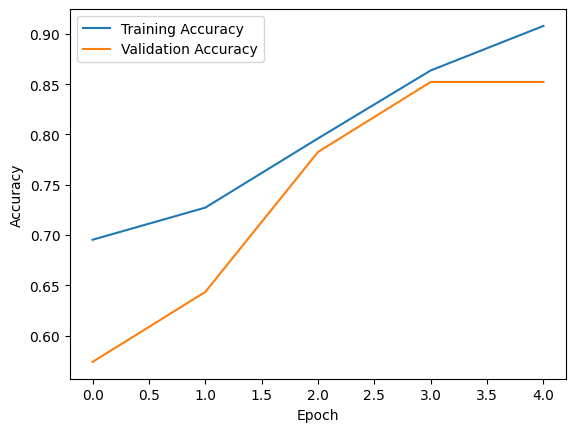

In [ ]:

# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print(tokenizer)
# Save the trained model





model.save('sentiment_analysis_model.h5')

In [ ]:
# Example prediction
example_text = "cryptocurrency is amazing."
if "cryptocurrency" in example_text or "crypto" in example_text:
    example_sequence = tokenizer.texts_to_sequences([example_text])
    example_padded = pad_sequences(example_sequence, maxlen=max_len, padding='post')
    sentiment_prediction = model.predict(example_padded)
    sentiment_label = "positive" if sentiment_prediction > 0.5 else "negative"
    print(f"\nInput Text: {example_text} \nSentiment Prediction: {sentiment_label}")
else:
    print("Invalid text. Please talk about cryptocurrency or crypto.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step

Input Text: cryptocurrency is amazing. 
Sentiment Prediction: positive


In [ ]:
# Function for predicting labels on a new dataset with positive/negative labels
def predict_labels_on_new_data(model, tokenizer, max_len, input_file_path):
    # Load the new data
    new_df = pd.read_csv('/content/testfile2.csv')

    # Preprocess the text
    new_df['text'] = new_df['text'].apply(preprocess_text)

    # Tokenize and pad the sequences
    new_sequences = tokenizer.texts_to_sequences(new_df['text'])
    new_padded = pad_sequences(new_sequences, maxlen=max_len, padding='post')

    # Make predictions
    predictions = model.predict(new_padded)
    predictions = np.round(predictions).flatten().astype(int)

    # Map numerical labels to positive/negative strings
    new_df['predicted_label'] = predictions
    new_df['predicted_sentiment'] = new_df['predicted_label'].map({0: 'negative', 1: 'positive'})

    return new_df[['text', 'predicted_sentiment']]

# Example usage:
new_data_file_path = '/content/testfile2.csv'
predictions_df = predict_labels_on_new_data(model, tokenizer, max_len, new_data_file_path)
print(predictions_df)
